<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/gridsearch_rnn_model_scaled_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# overview

Uses actions and an input state to predict the output state.

# imports

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import math
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras import metrics

2.0.0


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11725221820837674663
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13812874479073028021
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5434169764358397968
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10379750410238614876
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# mount drive

In [0]:
file = 'dataset_all_01.csv'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
working dir: /content/drive/My Drive/xplane_data


# load and prepare data

## define features (actions & states)
actions and states at time t are the input for the network.

the states at time t + 1 are the desired output of the network.


In [0]:
col_m_time      = '   missn,_time '
col_t_time      = '   _totl,_time '
col_yaw_v       = '   ____Q,rad/s '

col_yaw_deg     = '   _beta,__deg '
col_roll_deg    = '   _roll,__deg '
col_roll_v      = '   ____R,rad/s '
col_pitch_deg   = '   pitch,__deg '
col_pitch_v     = '   ____P,rad/s '
col_alt         = '   __alt,ftmsl '
col_vv          = '   __VVI,__fpm '
col_v           = '   Vtrue,_ktas '
col_rpm_prop    = '   rpm_1,_prop '
col_throttle     = '   thro1,_part '

cols_state = [ 
    col_yaw_v,
    col_yaw_deg,
    col_roll_deg,
    col_roll_v,
    col_pitch_deg,
    col_pitch_v,
    col_vv,
    col_alt,
    col_v,
    col_rpm_prop,
    col_throttle,
]

cols_time = [
    col_m_time,
    col_t_time,
]

col_elev_servo                  = '   _elev,servo '
col_ailrn_servo                  = '   ailrn,servo '
col_ruddr_servo                  = '   ruddr,servo '

cols_action = [
    col_elev_servo,
    col_ailrn_servo,
    col_ruddr_servo
]

# all input columns
cols_features = []
cols_features.extend(cols_state)
cols_features.extend(cols_action)

# orga column
col_dataset_index = 'dataset_index'
col_maneuver_index = 'maneuver_index'
col_maneuver_name = 'maneuver_name'
col_maneuver_datapoint_index = 'maneuver_datapoint_index'
col_maneuver_type = 'maneuver_type'


label_prefix = 't+1_'
cols_label = [label_prefix + col_state for col_state in cols_state]
print(cols_label)


['t+1_   ____Q,rad/s ', 't+1_   _beta,__deg ', 't+1_   _roll,__deg ', 't+1_   ____R,rad/s ', 't+1_   pitch,__deg ', 't+1_   ____P,rad/s ', 't+1_   __VVI,__fpm ', 't+1_   __alt,ftmsl ', 't+1_   Vtrue,_ktas ', 't+1_   rpm_1,_prop ', 't+1_   thro1,_part ']


## load data

In [0]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter=',', usecols = columns, 
                       float_precision='high')

df_features = load_xplane_csv(file, cols_features)

df_labels = load_xplane_csv(file, cols_label)

print(len(df_features))
print(len(df_labels))
assert(len(df_features) == len(df_labels))


477893
477893


## drop nan in features and labels

drop nan rows in both features and in labels

In [0]:
df_nan = df_labels.isna().any(axis=1)

for i in range(0, len(df_nan)):
  if df_nan[i] == True:
    df_features.drop(index=i, inplace=True)

df_labels.dropna(inplace=True)

print(len(df_features))
print(len(df_labels))

477290
477290


In [0]:
def split_train_test(dataset):
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test


## split data

In [0]:
features = df_features.values
labels = df_labels.values

In [0]:
train_X, test_X, train_Y, test_Y  = train_test_split(features,labels, test_size=0.2, random_state=42)

In [0]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(381832, 14)
(381832, 11)
(95458, 14)
(95458, 11)


## scale data

In [0]:
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_X)

train_X = feature_scaler.transform(train_X)
test_X = feature_scaler.transform(test_X)


In [0]:
label_scaler = MinMaxScaler()
label_scaler.fit(train_Y)

train_Y = label_scaler.transform(train_Y)
test_Y = label_scaler.transform(test_Y)

In [0]:
# create scaled df
scaled_df_features = pd.DataFrame(feature_scaler.transform(df_features), columns=df_features.columns)
scaled_df_labels = pd.DataFrame(label_scaler.transform(df_labels), columns=df_labels.columns)

In [0]:
df_features.describe()

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.0
mean,119.567353,31.868167,0.003814,-0.000023,-0.001840,-0.653563,-0.791051,0.006402,2714.494715,0.837601,2490.420838,-0.000023,-0.014557,0.0
std,10.113279,274.992679,0.007108,0.017348,0.023905,1.684671,8.876412,0.137679,1357.480837,0.082115,127.216137,0.002304,0.022662,0.0
min,66.424780,-1917.888180,-0.039450,-0.109810,-0.054820,-9.313510,-23.851520,-0.689970,805.092900,0.796080,2106.257810,-0.089790,-0.159740,0.0
25%,116.120002,-38.766265,-0.000010,-0.000410,-0.010880,-1.284538,-4.070882,-0.082300,1411.464812,0.796080,2424.051882,-0.000110,-0.017030,0.0
50%,118.825780,0.342395,0.001120,-0.000000,-0.000020,-0.787040,-0.104720,0.004390,2622.403565,0.796080,2458.394655,0.000000,-0.015220,0.0
75%,122.744895,165.376283,0.010170,0.000390,0.000847,-0.151363,0.212638,0.073260,3896.206053,0.796080,2504.543460,0.000070,-0.011370,0.0
max,155.436650,978.538330,0.041650,0.111310,0.055400,11.796170,25.924920,0.353550,5080.888180,1.000000,2811.808840,0.045100,0.124900,0.0


In [0]:
scaled_df_features.describe()

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,4.772900e+05,477290.000000,477290.000000,477290.000000,477290.000000,477290.0
mean,0.597028,0.673159,0.533466,0.496506,0.480678,0.410273,0.463281,0.667330,4.465606e-01,0.203613,0.544487,0.665484,0.510059,0.0
std,0.113617,0.094942,0.087647,0.078456,0.216880,0.079813,0.178326,0.131938,3.174807e-01,0.402681,0.180307,0.017080,0.079616,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.566223e-07,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.558299,0.648773,0.486313,0.494754,0.398657,0.380380,0.397390,0.582327,1.418146e-01,0.000000,0.450420,0.664838,0.501370,0.0
50%,0.588697,0.662275,0.500247,0.496608,0.497187,0.403949,0.477069,0.665402,4.250228e-01,0.000000,0.499095,0.665653,0.507729,0.0
75%,0.632726,0.719253,0.611837,0.498372,0.505058,0.434065,0.483445,0.731399,7.229333e-01,0.000000,0.564503,0.666172,0.521255,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000090,1.000000,1.000000,1.000001e+00,1.000000,1.000000,1.000000,1.000000,0.0


In [0]:
df_labels.describe()

,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.003815,0.006402,-0.791050,-0.001840,-0.653565,-0.000023,31.866864,2714.494657,119.567394,2490.421446,0.837601
std,0.007105,0.137680,8.876411,0.023905,1.684673,0.017348,274.991234,1357.480898,10.113312,127.216670,0.082115
min,-0.038680,-0.689970,-23.851520,-0.054820,-9.313510,-0.109810,-1917.888180,805.092900,66.424780,2106.257810,0.796080
25%,-0.000010,-0.082300,-4.070882,-0.010888,-1.284488,-0.000410,-38.766265,1411.464812,116.120015,2424.051882,0.796080
50%,0.001120,0.004390,-0.104720,-0.000020,-0.787045,0.000000,0.342395,2622.403565,118.825780,2458.394900,0.796080
75%,0.010160,0.073260,0.212860,0.000850,-0.151363,0.000390,165.372623,3896.206053,122.745007,2504.543950,0.796080
max,0.041650,0.353550,25.924920,0.055400,11.796170,0.111310,978.538330,5080.888180,155.436650,2811.808840,1.000000


In [0]:
scaled_df_labels.describe()

,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.529000,0.667368,0.463281,0.480678,0.410236,0.496619,0.673159,0.446561,0.597028,0.544487,0.203615
std,0.088447,0.131945,0.178326,0.216880,0.079806,0.078474,0.094942,0.317480,0.113618,0.180308,0.402682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.481389,0.582361,0.397390,0.398589,0.380348,0.494866,0.648773,0.141815,0.558299,0.450420,0.000000
50%,0.495456,0.665440,0.477069,0.497187,0.403913,0.496720,0.662275,0.425023,0.588697,0.499095,0.000000
75%,0.607992,0.731442,0.483449,0.505081,0.434026,0.498485,0.719252,0.722933,0.632727,0.564504,0.000000
max,1.000000,1.000058,1.000000,1.000000,1.000000,1.000226,1.000000,1.000000,1.000000,1.000000,1.000000


# train models

## define callbacks functions

In [0]:
def prepare_tensorboard_callback(model_name=''):
  logs_base_dir = "./tensorbaord_logs"
  model_log_dir = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
  target_log_dir = os.path.join(logs_base_dir, model_log_dir)
  os.makedirs(target_log_dir, exist_ok=True)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(target_log_dir, histogram_freq=1)
  return tensorboard_callback


In [0]:
def prepare_checkpoint_callback(model_name):
  checkpoint_base_dir = './checkpoints'
  os.makedirs(checkpoint_base_dir, exist_ok=True)
  filepath = os.path.join(checkpoint_base_dir, 'cp_'+ model_name)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                  save_weights_only=True,
                                                  verbose=1)
  return cp_callback 

## define plot_and_save functions

In [0]:
base_folder = './results'
notebook_folder = 'gridsearch_model_scaled_more'
results_folder = os.path.join(base_folder, notebook_folder)
os.makedirs(results_folder, exist_ok=True)
print('results_folder : ', results_folder)

saved_model_weight = 'saved_weights'
saved_model_weight_path = os.path.join(results_folder, saved_model_weight)
os.makedirs(saved_model_weight_path, exist_ok=True)


results_folder :  ./results/gridsearch_model_scaled_more


### loss historie

In [0]:
def save_plots_before_show(diagramm_name):
  if not os.path.exists(results_folder):
      os.makedirs(diagramm_folder)

  plt.savefig(results_folder + '/' + diagramm_name +'.pdf')
  plt.savefig(results_folder + '/' + diagramm_name +'.svg')
  plt.savefig(results_folder + '/' + diagramm_name +'.png')

def pas_history(model_tupels, histories, key='mean_squared_error'):
  model_names = [model_tupel[0] for model_tupel in model_tupels]
  plt.figure(figsize=(16,10))
  for i, history in enumerate(histories):
    history_epoch= range(0, len(history['loss']) )

    val = plt.plot(history_epoch, history['val_'+key],
                   '--', label=model_names[i]+' Val')
    plt.plot(history_epoch, history[key], color=val[0].get_color(),
             label=model_names[i]+' Train')

  plt.xlabel('Epochs')
  plt.yscale("log")
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history_epoch)])
  save_plots_before_show('history_loss'+'_'+key)
  plt.show()

### metrics (overall and for all single targets )



In [0]:
def pas_metrics_scaled(model_tupel):
  model_name = model_tupel[0]
  model = model_tupel[1]
  df = _df_prediction_metrics(model, scaled=True)
  file_path = os.path.join(results_folder, model_name + '_scaled.csv')
  df.to_csv(path_or_buf=file_path)
  return df
  
def pas_metrics(model_tupel):
  model_name = model_tupel[0]
  model = model_tupel[1]
  df = _df_prediction_metrics(model, scaled=False)
  file_path = os.path.join(results_folder, model_name + '.csv')
  df.to_csv(path_or_buf=file_path)
  return df


def _df_prediction_metrics(model, scaled):
  '''
  creates describe dataframe of labels and 
  connect them with mse,rmse and mae per target and overall 
  '''
  pred_Y = model.predict(test_X)
  
  if scaled:
    labels = scaled_df_labels
    truth_Y = test_Y
  else:
    labels = df_labels
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)


  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  rmses = np.array([math.sqrt(mse) for mse in mses])
  maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_describe = labels.describe()
  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=['mses'],     # index
            columns=labels.columns)  #  column names
  df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
        index=['rmes'],     # index
        columns=labels.columns)  #  column names
  df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
        index=['maes'],     # index
        columns=labels.columns)  #  column names
  
  
  df_mse_all = pd.DataFrame(data=mse,    # values
            index=['mse'],     # index
            columns=labels.columns)  #  column names
  df_rmse_all = pd.DataFrame(data=rmse,    # values
        index=['rme'],     # index
        columns=labels.columns)  #  column names
  df_mae_all = pd.DataFrame(data=mae,    # values
        index=['mae'],     # index
        columns=labels.columns)  #  column names
  

  metrics = [df_mse_per_feature, df_rmse_per_feature, df_mae_per_feature, 
             df_mse_all,df_rmse_all,df_mae_all]
  return df_describe.append(metrics)

## define models

In [0]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]

def create_model(model_name, layers, keras_activation, kernel_initializer, 
                 loss, metrics):
  if not layers:
    raise Exception('No layers defined. Expected in format [100,100]') 

  model = keras.Sequential(name=model_name)
  
  model.add(Dense(layers[0],input_shape=(features_nr,), 
                          kernel_initializer=kernel_initializer))
  model.add(keras_activation())

  for i in range(1, len(layers)):
    layer_val = layers[i]
    model.add(Dense(layer_val, kernel_initializer=kernel_initializer))
    model.add(keras_activation())

  model.add(Dense(target_nr ))

  model.compile(optimizer='adam',
                        loss=loss,
                        metrics=metrics)

  model.summary()
  print(model.to_json())
  return (model_name, model)


In [0]:
loss='mean_squared_error',
metrics=['mean_squared_error', 'mean_absolute_error']


baseline_without_bn = create_model('baseline_without_bn', [1200, 600, 600], 
                                   ReLU, 'he_uniform', 
                                  loss, metrics)

baseline_without_bn_elu = create_model('baseline_without_bn_elu', 
                                       [1200, 600, 600], ELU, 'he_uniform', 
             loss, metrics)


model_3x40 = create_model('model_3x40', [400, 400, 400],  ReLU, 'he_uniform', 
             loss, metrics)

model_2x50 = create_model('model_2x50', [50, 50], ReLU, 'he_uniform', 
             loss, metrics)

model_3x50 = create_model('model_3x50', [50, 50, 50], ReLU, 'he_uniform', 
             loss, metrics)

model_3x25 = create_model('model_3x25', [25, 25, 25], ReLU, 'he_uniform', 
             loss, metrics)




models = [baseline_without_bn_elu, baseline_without_bn_elu, 
          model_3x40, model_2x50, model_3x50,model_3x25]

Model: "baseline_without_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1200)              18000     
_________________________________________________________________
re_lu_14 (ReLU)              (None, 1200)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 600)               720600    
_________________________________________________________________
re_lu_15 (ReLU)              (None, 600)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 600)               360600    
_________________________________________________________________
re_lu_16 (ReLU)              (None, 600)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 11)        

## train, save and load model

In [0]:
def train_model(model_tupel, epochs, batch_size):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  callbacks = [
              #prepare_checkpoint_callback(model_name=model_name),
              prepare_tensorboard_callback(model_name=model_name)
              ]

  history = keras_model.fit(train_X,
                            train_Y,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(test_X, test_Y),
                            verbose=2,
                            callbacks=callbacks
                            )
  return history  

def _format_model_path(model_name):
  file_name = '{}_end'.format(model_name)
  return os.path.join(saved_model_weight_path, file_name)

def save_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  keras_model.save_weights(file_path)

def load_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  exact_file_path = file_path + '.index'
  if os.path.isfile(exact_file_path):
    print('load model {}'.format(model_name))
    keras_model.load_weights(file_path)
    return True
  else:
    return False

def _format_history_path(model_name):
  file_name = '{}_history_dict'.format(model_name)
  return os.path.join(results_folder, file_name)
  

def save_history(model_tupel, history):
  file_path = _format_history_path(model_tupel[0])
  with open(file_path, 'wb') as file_hist:
        pickle.dump(history.history, file_hist)
  

def load_history(model_tupel):
  file_path = _format_history_path(model_tupel[0])
  if not os.path.isfile(file_path):
    return dict()
  with open(file_path, 'rb') as file_hist:
    return pickle.load(file_hist)

In [0]:
histories = []
for model in models:
  if not load_model(model):
    print(model[0])
    history = train_model(model, epochs=10, batch_size=32)
    save_model(model)
    save_history(model, history)
    histories.append(history.history)
    print('*******************')
  else:
    history = load_history(model)
    histories.append(history)

baseline_without_bn_elu
Train on 381832 samples, validate on 95458 samples
Epoch 1/10
381832/381832 - 68s - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0223 - val_loss: 1.4780e-04 - val_mean_squared_error: 1.4780e-04 - val_mean_absolute_error: 0.0096
Epoch 2/10
381832/381832 - 67s - loss: 4.4739e-04 - mean_squared_error: 4.4739e-04 - mean_absolute_error: 0.0156 - val_loss: 3.4608e-04 - val_mean_squared_error: 3.4608e-04 - val_mean_absolute_error: 0.0154
Epoch 3/10
381832/381832 - 67s - loss: 4.0048e-04 - mean_squared_error: 4.0048e-04 - mean_absolute_error: 0.0145 - val_loss: 2.9870e-04 - val_mean_squared_error: 2.9870e-04 - val_mean_absolute_error: 0.0124
Epoch 4/10
381832/381832 - 66s - loss: 3.7563e-04 - mean_squared_error: 3.7563e-04 - mean_absolute_error: 0.0142 - val_loss: 5.3683e-04 - val_mean_squared_error: 5.3683e-04 - val_mean_absolute_error: 0.0172
Epoch 5/10
381832/381832 - 67s - loss: 3.6506e-04 - mean_squared_error: 3.6506e-04 - mean_absolute_error:

## visualize

### Test & Training Loss

In [0]:
for i, history in enumerate(histories):
  last_loss = history['loss'][-1]
  last_val_loss = history['val_loss'][-1]
  model_name = models[i][0]
  print('{} model last loss: {}'.format(model_name,last_loss))
  print('{} model last val loss: {}'.format(model_name,last_val_loss))
  print('*******')

baseline_without_bn_elu model last loss: 0.0003510484156598013
baseline_without_bn_elu model last val loss: 8.775424725603071e-05
*******
baseline_without_bn_elu model last loss: 0.0003510484156598013
baseline_without_bn_elu model last val loss: 8.775424725603071e-05
*******
model_3x40 model last loss: 6.1252898499820775e-06
model_3x40 model last val loss: 3.890762899637884e-06
*******
model_2x50 model last loss: 4.010503187389436e-06
model_2x50 model last val loss: 3.0286456483792197e-06
*******
model_3x50 model last loss: 4.569446331639252e-06
model_3x50 model last val loss: 5.0797881042760295e-06
*******
model_3x25 model last loss: 4.2479259240670715e-06
model_3x25 model last val loss: 5.069218745883315e-06
*******


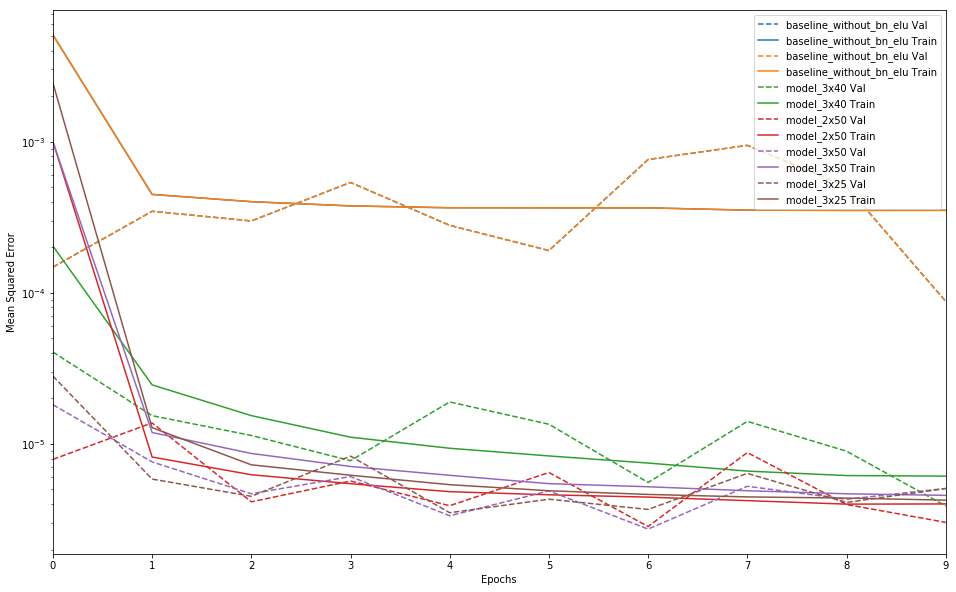

In [0]:
pas_history(models, histories=histories)


### MSE per target (scaled)

In [0]:
for model_tupel in models:
  df = pas_metrics_scaled(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                         'display.width', 1000): 
    print(df)
  print('*********************************************************')

baseline_without_bn_elu
       t+1_   ____Q,rad/s   t+1_   _beta,__deg   t+1_   _roll,__deg   t+1_   ____R,rad/s   t+1_   pitch,__deg   t+1_   ____P,rad/s   t+1_   __VVI,__fpm   t+1_   __alt,ftmsl   t+1_   Vtrue,_ktas   t+1_   rpm_1,_prop   t+1_   thro1,_part 
count        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000
mean              0.529000             0.667368             0.463281             0.480678             0.410236             0.496619             0.673159             0.446561             0.597028             0.544487             0.203615
std               0.088447             0.131945             0.178326             0.216880             0.079806             0.078474             0.094942             0.317480             0.113618             0.180308             0.402682
min               0.000000  

### MSE per target (unscaled)

In [0]:
for mode_tupel in models:
  df = pas_metrics(mode_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.width', 1000):  
    print(df)
  print('*********************************************************')

model_3x25
       t+1_   ____Q,rad/s   t+1_   _beta,__deg   t+1_   _roll,__deg   t+1_   ____R,rad/s   t+1_   pitch,__deg   t+1_   ____P,rad/s   t+1_   __VVI,__fpm   t+1_   __alt,ftmsl   t+1_   Vtrue,_ktas   t+1_   rpm_1,_prop   t+1_   thro1,_part 
count        477290.000000        477290.000000        477290.000000         4.772900e+05        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000        477290.000000         4.772900e+05
mean              0.003815             0.006402            -0.791050        -1.839620e-03            -0.653565            -0.000023            31.866864          2714.494657           119.567394          2490.421446         8.376013e-01
std               0.007105             0.137680             8.876411         2.390454e-02             1.684673             0.017348           274.991234          1357.480898            10.113312           127.216670         8.211498e-02
min              -0.038680            -0.